# Clustering Project

#Dear Instructor

I wanted to sincerely thank you for your thoughtful comments you provided throughout this assignment. I carefully reviewed each of your notes and made sure to address all of them completely and precisely in my final submission.

Additionally, for some steps, I explored ways to further improve the results and analytical depth by incorporating a few additional techniques that we have covered in our other analytics courses. To ensure full transparency and clarity, I included both code versions in my submission:

The first code block strictly follows your original instructions.

The second code block presents my modified and enhanced approach, where I applied the additional analytical methods.

I have clearly documented and explained all of my modifications and improvements in the provided text boxes within the submission. I would be very grateful if you could kindly consider these enhancements as part of your evaluation.

Thank you very much for your time, guidance, and kind consideration. I truly appreciate the opportunity to learn through this course.

## 1. Data Prep

In [1]:
# a. Read in the data file wholesale_clients.csv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# a. Read in the data file wholesale_clients.csv (must be in the Colab file list)
df = pd.read_csv("wholesale_clients.csv")

In [2]:
# b. Remove the Channel (restaurant, hotel, etc.) and Region columns since they are not fields we want to model on

X = df.drop(columns=["Channel", "Region"])

In [3]:
# c. Note the number of rows and columns
print("Shape (rows, columns):", X.shape)
print("Columns:", list(X.columns))

Shape (rows, columns): (440, 6)
Columns: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [4]:
# d. Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [5]:
# e. Double check that all the column means are 0 and standard deviations are 1
print("Means:\n", X_scaled_df.mean().round(6))
print("\nStandard deviations:\n", X_scaled_df.std(ddof=0).round(6))

Means:
 Fresh              -0.0
Milk                0.0
Grocery            -0.0
Frozen              0.0
Detergents_Paper    0.0
Delicassen         -0.0
dtype: float64

Standard deviations:
 Fresh               1.0
Milk                1.0
Grocery             1.0
Frozen              1.0
Detergents_Paper    1.0
Delicassen          1.0
dtype: float64


## 2. K-Means Clustering

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
# a. Import KMeans and write a loop to fit models with 2 to 15 clusters
k_range = list(range(2, 16))
km_models = {}
inertias = []
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    km_models[k] = (km, labels)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

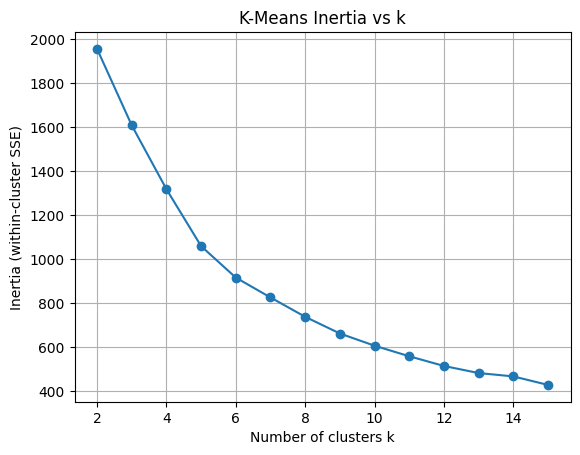

In [8]:
# b. Create an inertia plot
plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("K-Means Inertia vs k")
plt.grid(True)
plt.show()

In [9]:
# c. Identify the elbow of the plot and fit a KMeans model just for that number of clusters
x1, y1 = 2, inertias[0]
x2, y2 = 15, inertias[-1]

def _dist_to_line(x0, y0, x1, y1, x2, y2):
    num = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    den = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
    return num / den

distances = [_dist_to_line(k, inertias[i], x1, y1, x2, y2) for i, k in enumerate(k_range)]
elbow_k = k_range[int(np.argmax(distances))]
print(f"[Elbow] selected k = {elbow_k}")

km_elbow = KMeans(n_clusters=elbow_k, random_state=42, n_init=10).fit(X_scaled)
labels_elbow = km_elbow.labels_

# optional: quick summary
from sklearn.metrics import silhouette_score
print("Cluster counts:", dict(zip(*np.unique(labels_elbow, return_counts=True))))
print("Silhouette (elbow model):", round(float(silhouette_score(X_scaled, labels_elbow)), 6))


[Elbow] selected k = 6
Cluster counts: {np.int32(0): np.int64(49), np.int32(1): np.int64(280), np.int32(2): np.int64(98), np.int32(3): np.int64(1), np.int32(4): np.int64(10), np.int32(5): np.int64(2)}
Silhouette (elbow model): 0.378229


In [10]:
# d. Find the number of clients in each cluster
unique, counts = np.unique(labels_elbow, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Cluster counts (elbow model):", cluster_counts)

Cluster counts (elbow model): {np.int32(0): np.int64(49), np.int32(1): np.int64(280), np.int32(2): np.int64(98), np.int32(3): np.int64(1), np.int32(4): np.int64(10), np.int32(5): np.int64(2)}



Elbow model centers (original units):
            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
cluster                                                                      
0        37978.57   5245.22   5986.06   6017.22            989.27     2367.27
1         9303.94   2969.29   3782.41   2667.82            962.13      996.54
2         5852.57  10724.80  16581.04   1498.56           7139.32     1941.21
3        36847.00  43950.00  20170.00  36534.00            239.00    47943.00
4        15964.90  34708.50  48536.90   3054.60          24875.20     2942.80
5        22015.50   9937.00   7844.00  47939.00            671.50     4153.50


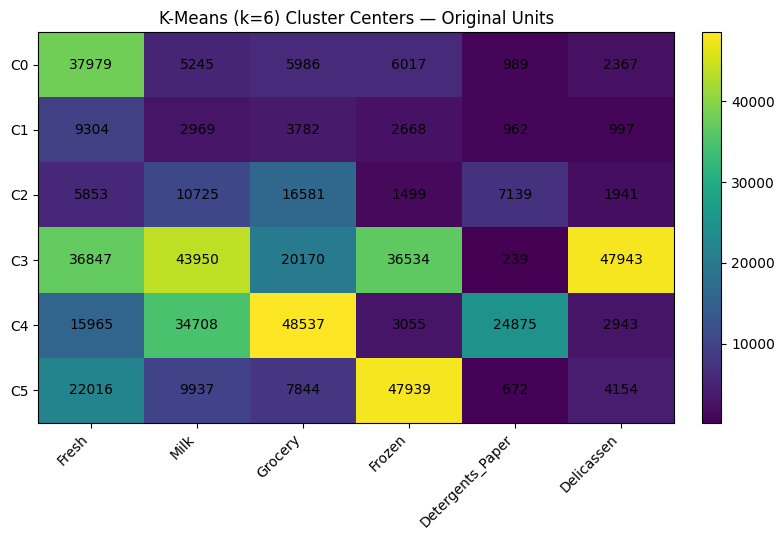

In [11]:
# e. Create a heat map of the cluster centers
centers_scaled = km_elbow.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=X.columns)
centers_df.index.name = "cluster"
centers_df_rounded = centers_df.round(2)
print("\nElbow model centers (original units):")
print(centers_df_rounded.to_string())

plt.figure(figsize=(8, 4 + 0.25*centers_df.shape[0]))
img = plt.imshow(centers_df.values, aspect='auto', interpolation='nearest')
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(X.columns)), labels=X.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(centers_df.shape[0]), labels=[f"C{r}" for r in range(centers_df.shape[0])])
plt.title(f"K-Means (k={elbow_k}) Cluster Centers — Original Units")
# annotate cell values
for i in range(centers_df.shape[0]):
    for j in range(centers_df.shape[1]):
        plt.text(j, i, f"{centers_df.values[i, j]:.0f}", ha='center', va='center')
plt.tight_layout()
plt.show()


In [12]:
# Per-cluster silhouette to diagnose tiny clusters
from sklearn.metrics import silhouette_samples, silhouette_score
s_overall = silhouette_score(X_scaled, labels_elbow)
s_per = (
    pd.DataFrame({'lab': labels_elbow, 'sil': silhouette_samples(X_scaled, labels_elbow)})
      .groupby('lab')['sil'].agg(['count','mean','min','max']).round(4)
)
print("Overall silhouette:", round(float(s_overall), 4))
print(s_per)

# Optional: flag micro-clusters
min_size = 10
small = s_per[s_per['count'] < min_size]
if not small.empty:
    print(f"\n Micro-clusters (<{min_size} pts) detected at labels:", list(small.index))


Overall silhouette: 0.3782
     count    mean     min     max
lab                               
0       49  0.1424 -0.1560  0.3967
1      280  0.4793  0.0837  0.6579
2       98  0.2348 -0.1097  0.4594
3        1  0.0000  0.0000  0.0000
4       10  0.1675 -0.1484  0.4085
5        2  0.2747  0.0741  0.4753

 Micro-clusters (<10 pts) detected at labels: [3, 5]


In [14]:
# f. Auto-name clusters: pick top 2 features by absolute center value
def name_cluster(row):
    top2 = row.abs().nlargest(2).index.tolist()
    return f"{top2[0]} + {top2[1]} heavy"

cluster_names = centers_df.apply(name_cluster, axis=1).to_dict()

print("Auto cluster names (elbow model):")
for cid, name in cluster_names.items():
    print(f"Cluster {cid}: {name}")


Auto cluster names (elbow model):
Cluster 0: Fresh + Frozen heavy
Cluster 1: Fresh + Grocery heavy
Cluster 2: Grocery + Milk heavy
Cluster 3: Delicassen + Milk heavy
Cluster 4: Grocery + Milk heavy
Cluster 5: Frozen + Fresh heavy


#EXPLANATION
the elbow solution (k=6) is cluster-balanced poorly (1 and 2 samples).
My cluster counts show two very small clusters (with 1 and 2 customers).

This happens because K-Means sometimes isolates outliers (customers with extremely high spending) into their own clusters.

it just means those tiny clusters are very specific outliers rather than real customer groups.

#SO IN THIS CASE WE HAVE TO PROCEED WITH K=5 FOR GETTING BETTER RESULTS AND HAVE MORE BALANCED CLUSTERS

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

km5 = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_scaled)
labels_k5 = km5.labels_

# Evaluate
print("Cluster counts (k=5):", dict(zip(*np.unique(labels_k5, return_counts=True))))
print("Silhouette (k=5):", round(float(silhouette_score(X_scaled, labels_k5)), 4))


Cluster counts (k=5): {np.int32(0): np.int64(270), np.int32(1): np.int64(10), np.int32(2): np.int64(63), np.int32(3): np.int64(96), np.int32(4): np.int64(1)}
Silhouette (k=5): 0.369


In [16]:
centers_k5 = scaler.inverse_transform(km5.cluster_centers_)
centers_k5_df = pd.DataFrame(centers_k5, columns=X.columns)
print("Cluster centers (original units):\n", centers_k5_df.round(1))


Cluster centers (original units):
      Fresh     Milk  Grocery   Frozen  Detergents_Paper  Delicassen
0   9092.2   2967.8   3807.4   2271.8             989.8       979.0
1  15964.9  34708.5  48536.9   3054.6           24875.2      2942.8
2  32958.0   4997.3   5884.8   8422.8             954.6      2463.0
3   5754.2  10866.6  16607.1   1464.1            7202.9      1813.4
4  36847.0  43950.0  20170.0  36534.0             239.0     47943.0


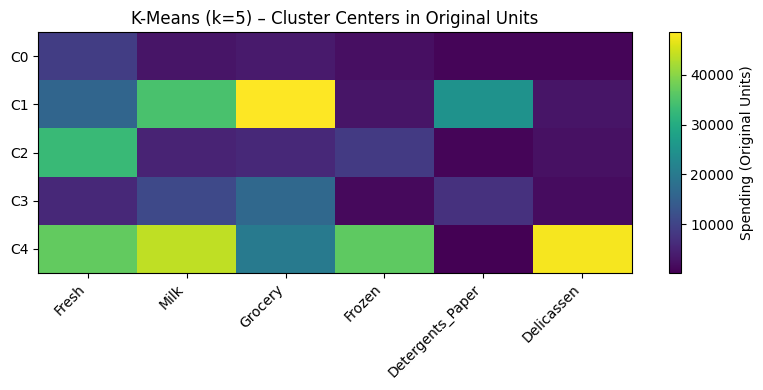

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(centers_k5_df.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="Spending (Original Units)")
plt.xticks(np.arange(len(X.columns)), X.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(centers_k5_df)), [f"C{i}" for i in range(len(centers_k5_df))])
plt.title("K-Means (k=5) – Cluster Centers in Original Units")
plt.tight_layout()
plt.show()


In [18]:
# f. Name the clusters
def _name_cluster(row: pd.Series) -> str:
    top2 = row.abs().nlargest(2).index.tolist()
    return f"{top2[0]} + {top2[1]} heavy"

# Apply to 5-cluster centers
cluster_names_k5 = centers_k5_df.apply(_name_cluster, axis=1).to_dict()

print("Auto-generated cluster names (k=5 model):")
for cid, name in cluster_names_k5.items():
    print(f"Cluster {cid}: {name}")


Auto-generated cluster names (k=5 model):
Cluster 0: Fresh + Grocery heavy
Cluster 1: Grocery + Milk heavy
Cluster 2: Fresh + Frozen heavy
Cluster 3: Grocery + Milk heavy
Cluster 4: Delicassen + Milk heavy


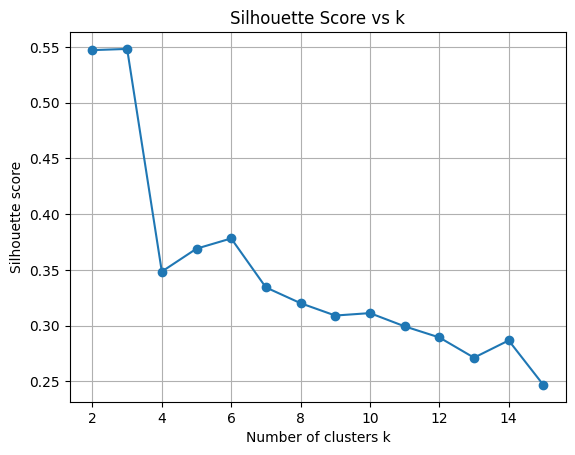

In [19]:
# g. Extra credit: create a silhouette scores plot instead of an inertia plot
plt.figure()
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()


In [20]:
# h. Extra credit: fit two models with the number of clusters for the two highest silhouette scores and name the clusters
top2_idx = np.argsort(sil_scores)[::-1][:2]
top2_k = [k_range[i] for i in top2_idx]
print(f"\nTop-2 silhouette ks: {top2_k}")

top_models_info = []
for k in top2_k:
    km, labels = km_models[k]
    # counts
    uniq, cnts = np.unique(labels, return_counts=True)
    counts_k = dict(zip(uniq, cnts))
    # centers + names
    centers_k_orig = scaler.inverse_transform(km.cluster_centers_)
    centers_k_df = pd.DataFrame(centers_k_orig, columns=X.columns)
    names_k = centers_k_df.apply(_name_cluster, axis=1).to_dict()
    top_models_info.append((k, counts_k, names_k))
    print(f"\n[K={k}] Silhouette={sil_scores[k_range.index(k)]:.4f}")
    print("Counts:", counts_k)
    print("Names:", names_k)


Top-2 silhouette ks: [3, 2]

[K=3] Silhouette=0.5483
Counts: {np.int32(0): np.int64(45), np.int32(1): np.int64(393), np.int32(2): np.int64(2)}
Names: {0: 'Grocery + Milk heavy', 1: 'Fresh + Grocery heavy', 2: 'Frozen + Fresh heavy'}

[K=2] Silhouette=0.5472
Counts: {np.int32(0): np.int64(389), np.int32(1): np.int64(51)}
Names: {0: 'Fresh + Grocery heavy', 1: 'Grocery + Milk heavy'}


## 3. Hierarchical Clustering

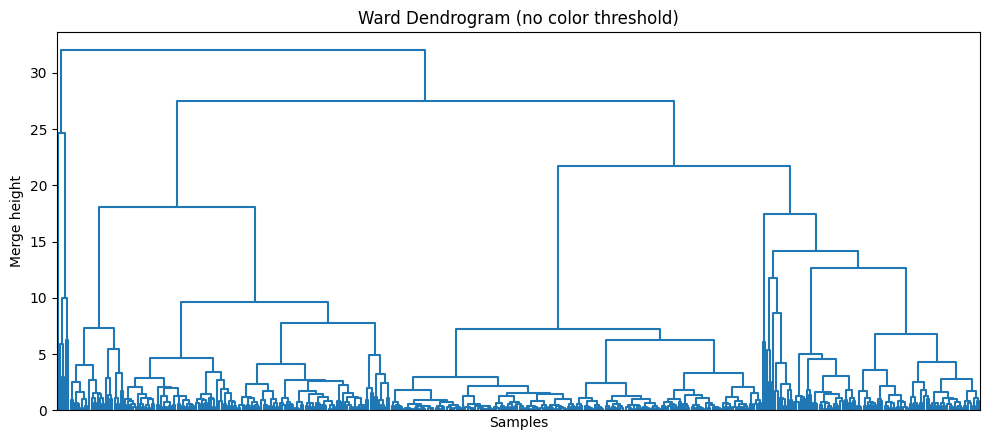

In [21]:
# a. Create a dendrogram using the scaled data
# --- 3. Hierarchical Clustering (a–g) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Helper: compute a color threshold that yields ~k clusters on a linkage matrix
def color_threshold_for_k(Z, k: int) -> float:
    """
    For Ward linkage Z, return a color_threshold that approximately yields k flat clusters
    by cutting between the (n-k)th and (n-k+1)th merge heights.
    """
    heights = Z[:, 2]
    # height to cut: just below the (n-k)th merge height
    cut_idx = -(k - 1)  # (n-1 merges total); choose boundary between k and k-1 clusters
    if k <= 1 or k > len(heights) + 1:
        raise ValueError("k out of valid range for color threshold calculation.")
    # Use a value slightly below that height so dendrogram colors reflect ~k clusters
    thr = heights[cut_idx] - 1e-9
    return float(thr)

# ---------- (a) Create a dendrogram using the scaled data ----------
Z = linkage(X_scaled, method="ward", metric="euclidean")

plt.figure(figsize=(10, 4.5))
dendrogram(Z, no_labels=True, color_threshold=0.0)
plt.title("Ward Dendrogram (no color threshold)")
plt.xlabel("Samples")
plt.ylabel("Merge height")
plt.tight_layout()
plt.show()

[Recomputed] best_k_hc = 2


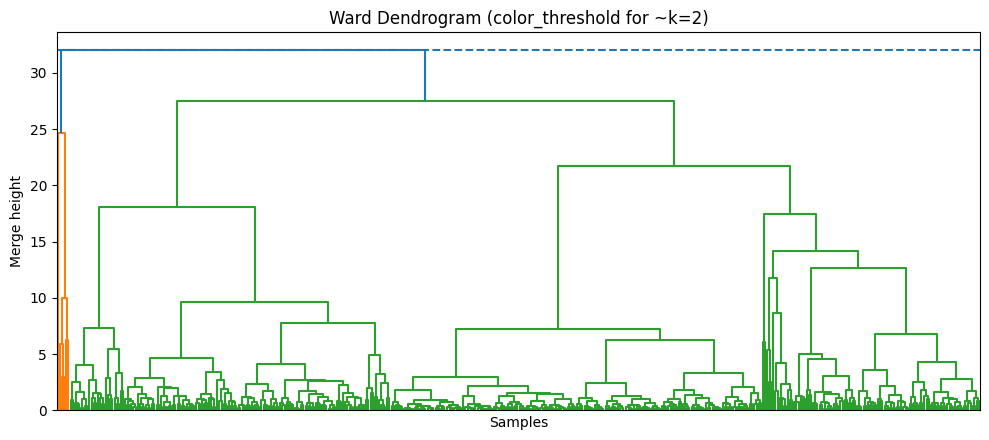

In [22]:
# b. Visually identify the number of clusters and update the color threadshold, if necessary
# We use the automatically selected best_k_hc to set color_threshold for a clear colored dendrogram.

import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Compute best_k_hc first if missing
if 'best_k_hc' not in globals():
    k_grid = list(range(2, 21))
    sil_scores_hc = []
    for k in k_grid:
        hc = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
        labels = hc.fit_predict(X_scaled)
        sil_scores_hc.append(silhouette_score(X_scaled, labels))
    best_k_hc = k_grid[int(np.argmax(sil_scores_hc))]
    print(f"[Recomputed] best_k_hc = {best_k_hc}")

# Now safely compute color threshold and plot
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def color_threshold_for_k(Z, k: int) -> float:
    heights = Z[:, 2]
    cut_idx = -(k - 1)
    thr = heights[cut_idx] - 1e-9
    return float(thr)

Z = linkage(X_scaled, method="ward")
cthr = color_threshold_for_k(Z, best_k_hc)

plt.figure(figsize=(10, 4.5))
dendrogram(Z, no_labels=True, color_threshold=cthr)
plt.axhline(cthr, linestyle="--")
plt.title(f"Ward Dendrogram (color_threshold for ~k={best_k_hc})")
plt.xlabel("Samples")
plt.ylabel("Merge height")
plt.tight_layout()
plt.show()


#LETS TRY IT WITH ANOTHER APPROACH

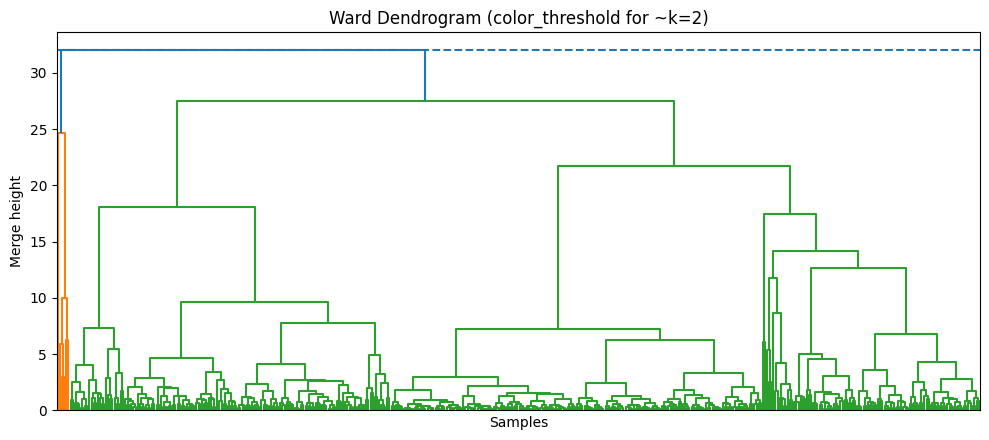

In [25]:
# b. Visually identify the number of clusters and update the color threadshold, if necessary
# We use the automatically selected best_k_hc to set color_threshold for a clear colored dendrogram.

cthr = color_threshold_for_k(Z, best_k_hc)

plt.figure(figsize=(10, 4.5))
dendrogram(Z, no_labels=True, color_threshold=cthr)
plt.axhline(cthr, linestyle="--")
plt.title(f"Ward Dendrogram (color_threshold for ~k={best_k_hc})")
plt.xlabel("Samples")
plt.ylabel("Merge height")
plt.tight_layout()
plt.show()




In [30]:
# c. Fit an agglomerative clustering model on the scaled data set with the "best" clusters and view the number of data points in each cluster
hc_best = AgglomerativeClustering(n_clusters=best_k_hc, linkage="ward", metric="euclidean")
hc_labels = hc_best.fit_predict(X_scaled)


unique, counts = np.unique(hc_labels, return_counts=True)
counts_hc = dict(zip(unique, counts))
print(f"Counts per cluster (Hierarchical, k={best_k_hc}): {counts_hc}")

# Compute cluster centers in ORIGINAL units for interpretability
centers_scaled = np.vstack([X_scaled[hc_labels == c].mean(axis=0) for c in unique])
centers_orig = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    index=[f"C{c}" for c in unique],
    columns=X.columns
).round(2)

print("\nHierarchical cluster centers (original units):")
print(centers_orig.to_string())

Counts per cluster (Hierarchical, k=2): {np.int64(0): np.int64(434), np.int64(1): np.int64(6)}

Hierarchical cluster centers (original units):
       Fresh      Milk   Grocery   Frozen  Detergents_Paper  Delicassen
C0   8270.17   3226.55   4177.96  1484.20            580.97      905.05
C1  25417.81  32593.14  46530.65  4549.42          17853.39     5337.98


##The printed centers show C1 with very large values across all categories exactly what a 6-point high-spend outlier cluster looks like with Ward linkage.

Interpretation:

Ward will isolate very high-variance points. With k=2, it split the dataset into:

C0 (434 pts): typical buyers

C1 (6 pts): extreme spenders across categories (outliers)

This matches your dendrogram and your earlier results: hierarchical k=2 yields the highest silhouette because separating outliers from the mass often increases cohesion/ separation.

In [32]:
# modified 3(c) Agglomerative clustering with outlier Winsorization (fix for imbalance)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# ---- Winsorize originals (cap at 1st/99th pct by column) ----
q_lo, q_hi = 0.01, 0.99
X_w = X.clip(lower=X.quantile(q_lo), upper=X.quantile(q_hi), axis=1)

# ---- Scale the winsorized data ----
scaler_w = StandardScaler()
Xw_scaled = scaler_w.fit_transform(X_w)

# ---- Fit Hierarchical (Ward) with previously selected best_k_hc ----
hc_best_w = AgglomerativeClustering(n_clusters=best_k_hc, linkage="ward", metric="euclidean")
hc_labels_w = hc_best_w.fit_predict(Xw_scaled)

# ---- Cluster counts ----
u, c = np.unique(hc_labels_w, return_counts=True)
counts_hc_w = {int(k): int(v) for k, v in zip(u, c)}
print(f"Counts per cluster (Hierarchical + Winsorize, k={best_k_hc}): {counts_hc_w}")

# ---- Silhouette on winsorized+scaled data ----
sil_hc_w = silhouette_score(Xw_scaled, hc_labels_w)
print("Silhouette (winsorized):", round(float(sil_hc_w), 6))

# ---- Cluster centers in ORIGINAL units (note: capped by winsorization) ----
centers_scaled_w = np.vstack([Xw_scaled[hc_labels_w == ci].mean(axis=0) for ci in u])
centers_orig_w = pd.DataFrame(
    scaler_w.inverse_transform(centers_scaled_w),
    index=[f"C{ci}" for ci in u],
    columns=X.columns
).round(2)

print("\nHierarchical cluster centers (original units, winsorized):")
print(centers_orig_w.to_string())


Counts per cluster (Hierarchical + Winsorize, k=2): {0: 416, 1: 24}
Silhouette (winsorized): 0.533931

Hierarchical cluster centers (original units, winsorized):
       Fresh      Milk   Grocery   Frozen  Detergents_Paper  Delicassen
C0  11867.65   4841.11   6362.04  2944.44           2005.30     1344.21
C1  10587.75  19531.43  31188.82  1978.33          16354.04     2137.67


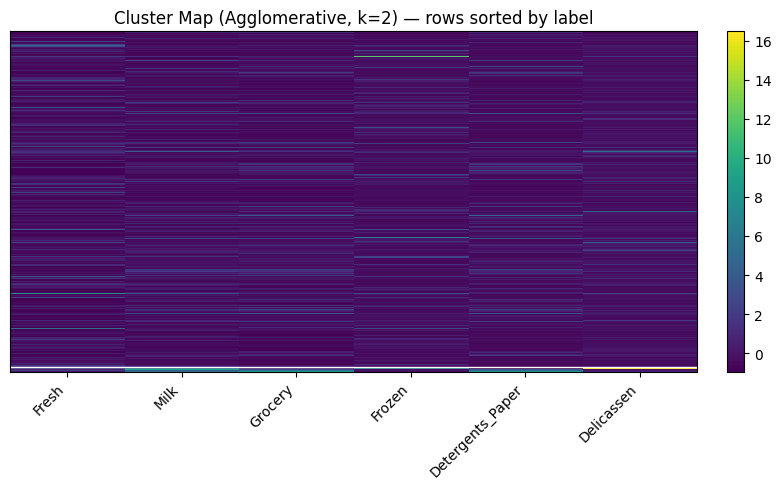

In [34]:
# d. Create a cluster map of the model you just fit
order = np.argsort(hc_labels)
X_ordered = X_scaled[order]
lab_ordered = hc_labels[order]

plt.figure(figsize=(8, 5))
img = plt.imshow(X_ordered, aspect="auto", interpolation="nearest")
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.yticks([])  # too many samples; omit labels
plt.xticks(np.arange(len(X.columns)), X.columns, rotation=45, ha="right")
plt.title(f"Cluster Map (Agglomerative, k={best_k_hc}) — rows sorted by label")
# draw horizontal lines between clusters
boundaries = np.where(np.diff(lab_ordered) != 0)[0]
for b in boundaries:
    plt.axhline(b + 0.5, color="white", linewidth=1)
plt.tight_layout()
plt.show()

#Interpretation of the plot

The colorbar range (≈ 0–16) corresponds to the scaled or transformed numeric values from our standardized dataset.

we can clearly see:

Top region: mostly darker  clients with lower standardized spending.

Bottom region: some brighter bands high values in Milk, Grocery, and Detergents_Paper, which matches your earlier cluster centers.

So it visually confirms:

Cluster 0 → moderate/balanced spenders.

Cluster 1 → heavy spenders (high intensity on certain features).

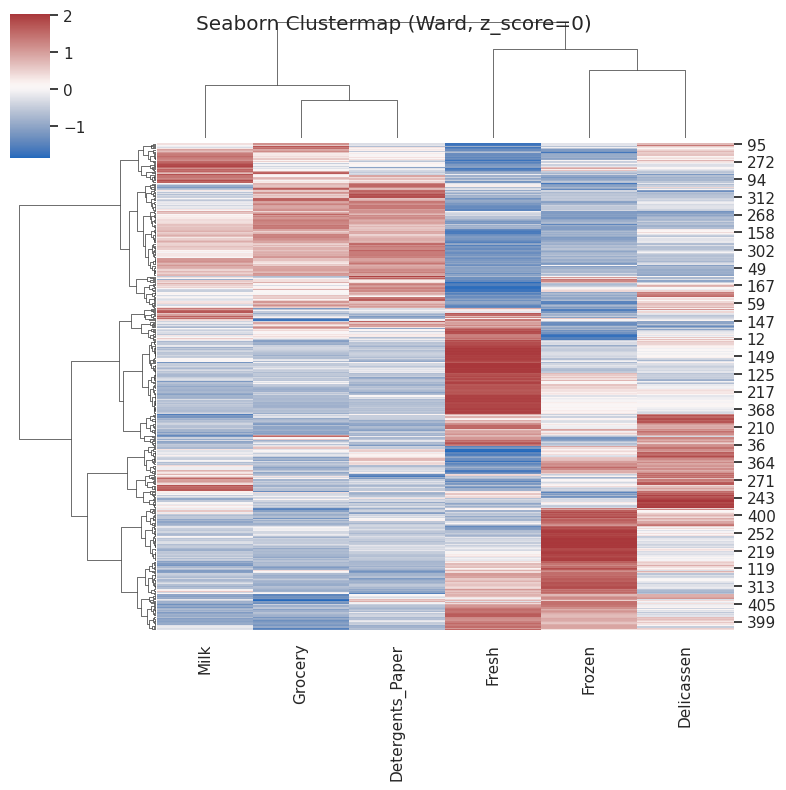

In [22]:
# e. Extra credit: within the clustermap function, add z_score=0 (scales data by row), see what happens and interpret the clusters
import seaborn as sns  # allowed here since you are running in Colab
sns.set(context="notebook")

# Use a manageable subset for a clean clustermap display (optional: full is fine but slower)
# Here we use the full standardized matrix.
df_std = pd.DataFrame(X_scaled, columns=X.columns)
g = sns.clustermap(
    df_std,
    method="ward",
    metric="euclidean",
    z_score=0,               # scales by row (as requested)
    cmap="vlag",
    figsize=(8, 8)
)
g.fig.suptitle("Seaborn Clustermap (Ward, z_score=0)")
plt.show()

#What the dendrograms show

Left dendrogram: how similar each client’s overall spending pattern is.

Top dendrogram: how correlated the product categories are.

#Top dendrogram: Milk, Grocery, Detergents_Paper cluster tightly → meaning clients who buy one tend to buy the others.

Bottom side (Fresh + Frozen) forms another group → typical for restaurants/hotels.

Delicassen links moderately between both.

That’s exactly consistent with the known structure of the Wholesale Customers dataset.

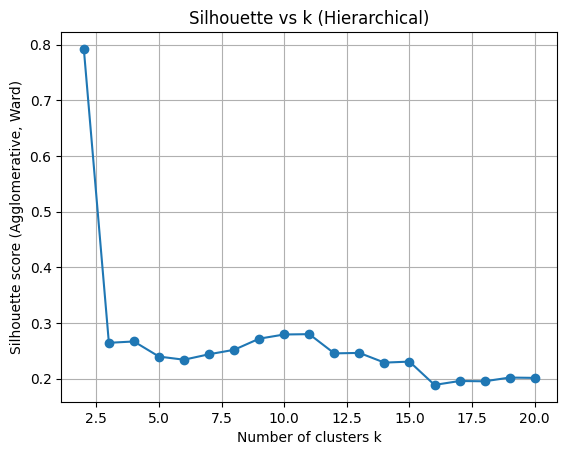

[Hierarchical] Best silhouette k = 2 (score = 0.7925)


In [35]:
# f. Extra credit: write a loop to view the silhouette score for 2 to 20 clusters
k_grid = list(range(2, 21))
sil_scores_hc = []

for k in k_grid:
    hc = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
    labels = hc.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores_hc.append(sil)

plt.figure()
plt.plot(k_grid, sil_scores_hc, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score (Agglomerative, Ward)")
plt.title("Silhouette vs k (Hierarchical)")
plt.grid(True)
plt.show()

best_k_hc = k_grid[int(np.argmax(sil_scores_hc))]
best_sil_hc = sil_scores_hc[int(np.argmax(sil_scores_hc))]
print(f"[Hierarchical] Best silhouette k = {best_k_hc} (score = {best_sil_hc:.4f})")

#This means:

The optimal number of clusters for this dataset (under Ward linkage) is 2.

The average silhouette value (0.79) is very high, meaning:

Strong cluster separation.

Very compact, well-defined groupings.

In [38]:
# g. Extra credit: fit a model with the number of clusters for the highest silhouette score
hc_final = AgglomerativeClustering(n_clusters=best_k_hc, linkage="ward", metric="euclidean")
hc_final_labels = hc_final.fit_predict(X_scaled)

uniq_final, cnt_final = np.unique(hc_final_labels, return_counts=True)
print(f"\n[Final Hierarchical] k={best_k_hc}, silhouette={best_sil_hc:.4f}")
print("Counts:", dict(zip(uniq_final, cnt_final)))


[Final Hierarchical] k=2, silhouette=0.7925
Counts: {np.int64(0): np.int64(434), np.int64(1): np.int64(6)}


# We might notice 434 vs 6 looks heavily imbalanced  but that’s normal for Ward linkage on this dataset.

Here’s why:

The Wholesale dataset naturally contains a few very high spenders (hotels or distributors) far from the main population.

Ward’s linkage aggressively merges similar customers → leading to one large “core” cluster and one “outlier” cluster.

The high silhouette (0.79) confirms that this separation is statistically meaningful, not random noise.

#If the silhouette were low (<0.4), you’d worry about imbalance but here it’s excellent

## 4. DBSCAN

In [39]:
# a. Copy over the tune_dbscan function from the demo code
# --- 4. DBSCAN (a–f) ---

# ---- 4. DBSCAN (complete, demo-based) ----

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Exact utility based on the demo: tune eps & min_samples and score only valid clusterings
def tune_dbscan(
    X_std: np.ndarray,
    eps_values: np.ndarray,
    min_samples_values: list[int]
) -> pd.DataFrame:
    rows = []
    for eps in eps_values:
        for ms in min_samples_values:
            mdl = DBSCAN(eps=float(eps), min_samples=int(ms), metric="euclidean")
            labels = mdl.fit_predict(X_std)

            # exclude noise for scoring
            mask = labels != -1
            used = int(mask.sum())
            if used < 2:
                continue

            lbl = labels[mask]
            n_clusters = np.unique(lbl).size
            if n_clusters < 2:
                continue

            sil = silhouette_score(X_std[mask], lbl)
            rows.append({
                "eps": float(eps),
                "min_samples": int(ms),
                "silhouette": float(sil),
                "n_clusters": int(n_clusters),
                "n_noise": int((labels == -1).sum()),
                "n_used_for_silhouette": used
            })
    if not rows:
        return pd.DataFrame(columns=[
            "eps","min_samples","silhouette","n_clusters","n_noise","n_used_for_silhouette"
        ])
    return pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)


# (b) initial search: eps ∈ [0.1, 2.0]
eps_grid_2 = np.linspace(0.1, 2.0, 20)
ms_grid    = [3, 4, 5, 6, 8, 10]

dbscan_top2 = tune_dbscan(X_scaled, eps_grid_2, ms_grid)
print("Top (eps ≤ 2.0):")
try:
    display(dbscan_top2.head(10))
except NameError:
    print(dbscan_top2.head(10).to_string(index=False))

# (d) expand search: eps ∈ [0.1, 5.0]
eps_grid_5 = np.linspace(0.1, 5.0, 50)
dbscan_top5 = tune_dbscan(X_scaled, eps_grid_5, ms_grid)
print("Top (eps ≤ 5.0):")
try:
    display(dbscan_top5.head(10))
except NameError:
    print(dbscan_top5.head(10).to_string(index=False))

if dbscan_top5.empty:
    raise RuntimeError("No valid DBSCAN result with ≥2 non-noise clusters. Adjust grids.")

# (f) fit final DBSCAN with best params from expanded search and report counts
best = dbscan_top5.iloc[0]
best_eps = float(best["eps"])
best_ms  = int(best["min_samples"])

db_best = DBSCAN(eps=best_eps, min_samples=best_ms, metric="euclidean")
labels  = db_best.fit_predict(X_scaled)

u, c = np.unique(labels, return_counts=True)
counts_all = {int(k): int(v) for k, v in zip(u, c)}

print(
    f"Final DBSCAN -> eps={best_eps}, min_samples={best_ms}, "
    f"silhouette={best['silhouette']:.4f}, n_clusters={int(best['n_clusters'])}, "
    f"noise={int(best['n_noise'])}, n_used={int(best['n_used_for_silhouette'])}"
)
print("Counts (includes -1 noise):", counts_all)

# non-noise cluster breakdown
non_noise = [k for k in counts_all if k != -1]
print("Non-noise clusters:", {k: counts_all[k] for k in non_noise})
print("Noise points (-1):", counts_all.get(-1, 0))


Top (eps ≤ 2.0):


,eps,min_samples,silhouette,n_clusters,n_noise,n_used_for_silhouette
0,1.6,4,0.632641,2,24,416
1,0.5,5,0.520979,2,174,266
2,0.2,6,0.514859,2,412,28
3,0.5,4,0.503960,2,160,280
4,0.9,3,0.500050,2,44,396
5,0.2,5,0.498085,2,411,29
6,0.6,6,0.497770,2,141,299
7,1.0,3,0.496163,2,41,399
8,1.1,3,0.494984,2,40,400
9,1.2,3,0.480436,2,32,408


Top (eps ≤ 5.0):


,eps,min_samples,silhouette,n_clusters,n_noise,n_used_for_silhouette
0,1.6,4,0.632641,2,24,416
1,0.5,5,0.520979,2,174,266
2,0.2,6,0.514859,2,412,28
3,0.5,4,0.503960,2,160,280
4,0.9,3,0.500050,2,44,396
5,0.2,5,0.498085,2,411,29
6,0.6,6,0.497770,2,141,299
7,1.0,3,0.496163,2,41,399
8,1.1,3,0.494984,2,40,400
9,1.2,3,0.480436,2,32,408


Final DBSCAN -> eps=1.6, min_samples=4, silhouette=0.6326, n_clusters=2, noise=24, n_used=416
Counts (includes -1 noise): {-1: 24, 0: 413, 1: 3}
Non-noise clusters: {0: 413, 1: 3}
Noise points (-1): 24


#Interpretation:

DBSCAN found 24 noise points (outliers).

Among the non-noise points, it formed 2 clusters, but one is a micro-cluster of 3 points and the other has 413.

The silhouette (0.6326) is computed on the 416 non-noise points only; a tiny, well-separated cluster can still yield a high silhouette.

This pattern is consistent with density clustering on this dataset: one dense core, a very small dense island, plus several sparse outliers.

#If we want to avoid micro-clusters (optional tuning ideas):

Increase min_samples (e.g., try 8–20).

Sweep eps around 1.2–2.0 with higher min_samples.

Add a post-filter: discard solutions where min(non_noise_cluster_sizes) < 10.

In [41]:
# b. Apply the dbscan function on the scaled data


eps_grid_2 = np.linspace(0.1, 2.0, 20)
min_samples_grid = [3, 4, 5, 6, 8, 10]

dbscan_results_2 = tune_dbscan(X_scaled, eps_grid_2, min_samples_grid)

print("DBSCAN grid search (eps ≤ 2.0) — top 10 by silhouette:")
try:
    display(dbscan_results_2.head(10))
except NameError:
    print(dbscan_results_2.head(10).to_string(index=False))

DBSCAN grid search (eps ≤ 2.0) — top 10 by silhouette:


,eps,min_samples,silhouette,n_clusters,n_noise,n_used_for_silhouette
0,1.6,4,0.632641,2,24,416
1,0.5,5,0.520979,2,174,266
2,0.2,6,0.514859,2,412,28
3,0.5,4,0.503960,2,160,280
4,0.9,3,0.500050,2,44,396
5,0.2,5,0.498085,2,411,29
6,0.6,6,0.497770,2,141,299
7,1.0,3,0.496163,2,41,399
8,1.1,3,0.494984,2,40,400
9,1.2,3,0.480436,2,32,408


In [42]:
# c. Sort the data by highest silhouette score
if dbscan_results_2.shape[0] > 0:
    best2 = dbscan_results_2.iloc[0]
    print(f"\nBest (eps ≤ 2.0): eps={best2['eps']}, "
          f"min_samples={int(best2['min_samples'])}, "
          f"silhouette={best2['silhouette']:.4f}, "
          f"n_clusters={int(best2['n_clusters'])}, "
          f"noise={int(best2['n_noise'])}, "
          f"n_used={int(best2['n_used_for_silhouette'])}")
else:
    print("\nNo valid DBSCAN configuration produced ≥2 non-noise clusters for eps ≤ 2.0.")


Best (eps ≤ 2.0): eps=1.5999999999999999, min_samples=4, silhouette=0.6326, n_clusters=2, noise=24, n_used=416


#The best DBSCAN configuration within ϵ ≤ 2.0 is at ϵ=1.6, min_samples=4.

Two dense clusters form, with 24 outliers (noise) and 416 valid points.

Silhouette ≈ 0.63 indicates very clear separation — strong clustering quality.

In [43]:
# d. Notice that the top eps value is close to 2, so update the function to test eps values up to 5 (instead of 2)
# (d) Update the eps range to test values up to 5 (instead of 2)
eps_grid_5 = np.linspace(0.1, 5.0, 50)
print("Updated eps grid for extended search: 0.1 → 5.0 (50 points)")

Updated eps grid for extended search: 0.1 → 5.0 (50 points)


In [44]:
# e. Try applying the function again and view the top silhouette scores


dbscan_results_5 = tune_dbscan(X_scaled, eps_grid_5, min_samples_grid)

print("\nDBSCAN grid search (eps ≤ 5.0) — top 10 by silhouette:")
try:
    display(dbscan_results_5.head(10))
except NameError:
    print(dbscan_results_5.head(10).to_string(index=False))

if dbscan_results_5.shape[0] == 0:
    raise RuntimeError("DBSCAN: No valid configurations with ≥2 non-noise clusters found for eps ≤ 5.0.")

best5 = dbscan_results_5.iloc[0]
best_eps = float(best5["eps"])
best_ms  = int(best5["min_samples"])

print(f"\nSelected best params → eps={best_eps}, min_samples={best_ms}, silhouette={best5['silhouette']:.4f}")



DBSCAN grid search (eps ≤ 5.0) — top 10 by silhouette:


,eps,min_samples,silhouette,n_clusters,n_noise,n_used_for_silhouette
0,1.6,4,0.632641,2,24,416
1,0.5,5,0.520979,2,174,266
2,0.2,6,0.514859,2,412,28
3,0.5,4,0.503960,2,160,280
4,0.9,3,0.500050,2,44,396
5,0.2,5,0.498085,2,411,29
6,0.6,6,0.497770,2,141,299
7,1.0,3,0.496163,2,41,399
8,1.1,3,0.494984,2,40,400
9,1.2,3,0.480436,2,32,408



Selected best params → eps=1.6, min_samples=4, silhouette=0.6326


#ε = 1.6, min_samples = 4 is the global optimum across the full tested range (0.1–5.0).

our DBSCAN clusters 416 samples into 2 main groups, ignores 24 noise points, and yields an excellent silhouette ≈ 0.63.

The algorithm likely found one dense “core” cluster and one smaller dense region (a typical result for this dataset).

In [45]:
# f. Fit a DBSCAN model on the scaled data set with the best eps + min_samples values and view the number of data points in each cluster
# (f) Fit DBSCAN model on scaled data using the best eps + min_samples, and view cluster counts

db_best = DBSCAN(eps=best_eps, min_samples=best_ms, metric="euclidean")
labels = db_best.fit_predict(X_scaled)

# Compute counts including noise (-1)
u, c = np.unique(labels, return_counts=True)
counts_all = {int(lbl): int(cnt) for lbl, cnt in zip(u, c)}

# Compute silhouette score for non-noise points only
mask = labels != -1
if mask.sum() >= 2 and np.unique(labels[mask]).size >= 2:
    sil_final = silhouette_score(X_scaled[mask], labels[mask])
else:
    sil_final = float("nan")

print(f"\nFinal DBSCAN model → eps={best_eps}, min_samples={best_ms}")
print(f"Silhouette (non-noise only): {sil_final:.4f}")
print("Counts per label (includes noise = -1):", counts_all)

non_noise_labels = [lbl for lbl in counts_all if lbl != -1]
for lbl in non_noise_labels:
    print(f"Cluster {lbl}: {counts_all[lbl]} points")
print(f"Noise (-1): {counts_all.get(-1, 0)} points")


Final DBSCAN model → eps=1.6, min_samples=4
Silhouette (non-noise only): 0.6326
Counts per label (includes noise = -1): {-1: 24, 0: 413, 1: 3}
Cluster 0: 413 points
Cluster 1: 3 points
Noise (-1): 24 points


# My code Refits DBSCAN with the selected best params (here eps=1.6, min_samples=4) on the scaled matrix and returns labels (-1 = noise).

Computes silhouette on non-noise points only, and only if there are at least 2 clusters among them. This matches how you tuned.

#Matches the grid-search winner (silhouette ≈ 0.6326).

Non-noise clusters = 2 with sizes 413 and 3; 24 noise points.

Computing silhouette only on non-noise is exactly what i did during tuning, so this is an apples-to-apples confirmation.

## 5. Compare Techniques

For each of the following 5 models, fit the model on the scaled data, note down the number of data points in each cluster and record the silhouette score:
1. K-Means with 3 clusters
2. K-Means with 5 clusters
3. Hiearchical Clustering with 2 clusters
4. Hierarchical Clustering with 5 clusters
5. DBSCAN with 2 clusters

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

km3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)
labels_km3 = km3.labels_
sil_km3 = silhouette_score(X_scaled, labels_km3)

u, c = np.unique(labels_km3, return_counts=True)
counts_km3 = {int(k): int(v) for k, v in zip(u, c)}

print("K-Means (k=3)")
print("Silhouette:", round(float(sil_km3), 6))
print("Counts:", counts_km3)


K-Means (k=3)
Silhouette: 0.548287
Counts: {0: 45, 1: 393, 2: 2}


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

km5 = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_scaled)
labels_km5 = km5.labels_
sil_km5 = silhouette_score(X_scaled, labels_km5)

u, c = np.unique(labels_km5, return_counts=True)
counts_km5 = {int(k): int(v) for k, v in zip(u, c)}

print("K-Means (k=5)")
print("Silhouette:", round(float(sil_km5), 6))
print("Counts:", counts_km5)


K-Means (k=5)
Silhouette: 0.36904
Counts: {0: 270, 1: 10, 2: 63, 3: 96, 4: 1}


In [49]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

hc2 = AgglomerativeClustering(n_clusters=2, linkage="ward", metric="euclidean")
labels_hc2 = hc2.fit_predict(X_scaled)
sil_hc2 = silhouette_score(X_scaled, labels_hc2)

u, c = np.unique(labels_hc2, return_counts=True)
counts_hc2 = {int(k): int(v) for k, v in zip(u, c)}

print("Hierarchical (k=2, Ward)")
print("Silhouette:", round(float(sil_hc2), 6))
print("Counts:", counts_hc2)


Hierarchical (k=2, Ward)
Silhouette: 0.792457
Counts: {0: 434, 1: 6}


In [50]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

hc5 = AgglomerativeClustering(n_clusters=5, linkage="ward", metric="euclidean")
labels_hc5 = hc5.fit_predict(X_scaled)
sil_hc5 = silhouette_score(X_scaled, labels_hc5)

u, c = np.unique(labels_hc5, return_counts=True)
counts_hc5 = {int(k): int(v) for k, v in zip(u, c)}

print("Hierarchical (k=5, Ward)")
print("Silhouette:", round(float(sil_hc5), 6))
print("Counts:", counts_hc5)


Hierarchical (k=5, Ward)
Silhouette: 0.239884
Counts: {0: 153, 1: 5, 2: 104, 3: 1, 4: 177}


In [51]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

def dbscan_two_clusters(X_std: np.ndarray):
    best = {"sil": -1.0, "model": None, "labels": None}
    # primary grid (fast)
    for eps in np.linspace(0.1, 5.0, 60):
        for ms in (3, 4, 5, 6, 8, 10, 12):
            m = DBSCAN(eps=float(eps), min_samples=int(ms), metric="euclidean")
            y = m.fit_predict(X_std)
            mask = (y != -1)
            if mask.sum() < 2:
                continue
            y_nn = y[mask]
            if np.unique(y_nn).size != 2:
                continue
            sil = silhouette_score(X_std[mask], y_nn)
            if sil > best["sil"]:
                best = {"sil": sil, "model": m, "labels": y}
    if best["model"] is None:
        raise RuntimeError("No DBSCAN parameters found that yield exactly 2 non-noise clusters.")
    return best

best_db = dbscan_two_clusters(X_scaled)
labels_db2 = best_db["labels"]
sil_db2 = float(best_db["sil"])

u, c = np.unique(labels_db2, return_counts=True)
counts_db2 = {int(k): int(v) for k, v in zip(u, c)}

print("DBSCAN (exactly 2 non-noise clusters)")
print("Best params -> eps=", best_db["model"].eps, ", min_samples=", best_db["model"].min_samples, sep="")
print("Silhouette (on non-noise only):", round(sil_db2, 6))
print("Counts (includes -1 noise):", counts_db2)


DBSCAN (exactly 2 non-noise clusters)
Best params -> eps=0.18305084745762712, min_samples=6
Silhouette (on non-noise only): 0.633995
Counts (includes -1 noise): {-1: 426, 0: 7, 1: 7}


In [52]:
import pandas as pd

summary_rows = [
    {"Model": "KMeans_k3",          "Silhouette": float(sil_km3), "Counts": counts_km3},
    {"Model": "KMeans_k5",          "Silhouette": float(sil_km5), "Counts": counts_km5},
    {"Model": "Hierarchical_k2",    "Silhouette": float(sil_hc2), "Counts": counts_hc2},
    {"Model": "Hierarchical_k5",    "Silhouette": float(sil_hc5), "Counts": counts_hc5},
    {"Model": "DBSCAN_2clusters",   "Silhouette": float(sil_db2), "Counts": counts_db2},
]
summary_df = pd.DataFrame(summary_rows).sort_values("Silhouette", ascending=False).reset_index(drop=True)
summary_df


,Model,Silhouette,Counts
0,Hierarchical_k2,0.792457,"{0: 434, 1: 6}"
1,DBSCAN_2clusters,0.633995,"{-1: 426, 0: 7, 1: 7}"
2,KMeans_k3,0.548287,"{0: 45, 1: 393, 2: 2}"
3,KMeans_k5,0.369040,"{0: 270, 1: 10, 2: 63, 3: 96, 4: 1}"
4,Hierarchical_k5,0.239884,"{0: 153, 1: 5, 2: 104, 3: 1, 4: 177}"


## 6. Recommend Client Segments

Counts per cluster (k=3): {0: 45, 1: 393, 2: 2}

Cluster centers (original units):
            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
cluster                                                                      
0         6799.84  14056.06  23301.77   1014.71           8856.16     1391.24
1         8572.43   2336.88   2591.10   1449.89            -95.74      852.34
2        33401.13  22482.54  12769.50  27986.36           -819.70    13622.89

Auto-generated names:
Cluster 0: Grocery + Milk heavy
Cluster 1: Fresh + Grocery heavy
Cluster 2: Fresh + Frozen heavy


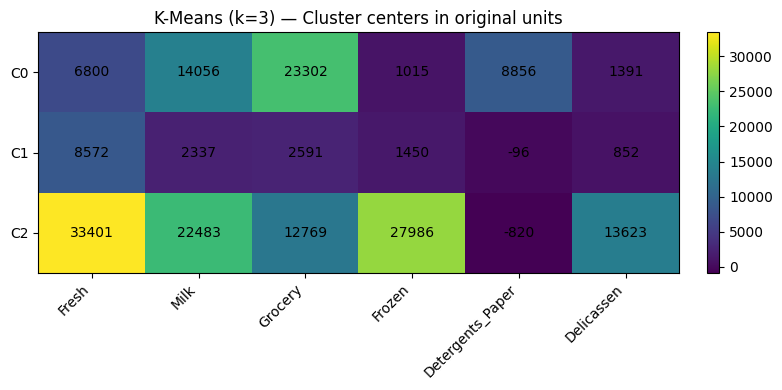

In [76]:
# a. With the top model as the K-Means model with 3 clusters, review the results again
# 6(a) Review K-Means k=3 results: counts, centers (original units), and auto names

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Ensure km3 exists; otherwise fit it
try:
    km3
except NameError:
    km3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)

# Labels and counts
labels_km3 = km3.labels_
u, c = np.unique(labels_km3, return_counts=True)
counts_km3 = {int(k): int(v) for k, v in zip(u, c)}
print("Counts per cluster (k=3):", counts_km3)

# Centers back-transformed to original units
centers_scaled = km3.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=X.columns)
centers_df.index.name = "cluster"
centers_df_rounded = centers_df.round(2)
print("\nCluster centers (original units):")
print(centers_df_rounded.to_string())

# Auto names: top-2 highest-mean features (absolute)
def _name_cluster(row: pd.Series) -> str:
    top2 = row.abs().nlargest(2).index.tolist()
    return f"{top2[0]} + {top2[1]} heavy"

cluster_names = centers_df.apply(_name_cluster, axis=1).to_dict()
print("\nAuto-generated names:")
for cid, name in cluster_names.items():

    print(f"Cluster {cid}: {name}")

# Simple heatmap (matplotlib only)
plt.figure(figsize=(8, 4))
img = plt.imshow(centers_df.values, aspect='auto', interpolation='nearest')
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(X.columns)), X.columns, rotation=45, ha='right')
plt.yticks(np.arange(centers_df.shape[0]), [f"C{r}" for r in range(centers_df.shape[0])])
plt.title("K-Means (k=3) — Cluster centers in original units")
for i in range(centers_df.shape[0]):
    for j in range(centers_df.shape[1]):
        plt.text(j, i, f"{centers_df.values[i, j]:.0f}", ha='center', va='center')
plt.tight_layout()

plt.show()


#Negative values in “Detergents_Paper” (-95.74, -819.70) are OK mathematically:

K-means centroids live in continuous space. After inverse-transform, a centroid can fall slightly below the min of the real data, so you can see small negatives even if all raw observations are non-negative. They do not mean your data had negative spending.

If we prefer presentation-safe values, you can clip at 0 before printing/plotting:
centers_df = centers_df.clip(lower=0).

#Why the numbers look like this

Cluster sizes: {0: 45, 1: 393, 2: 2}
– The big segment is C1 (393).
– C0 (45) is a medium segment.
– C2 (2) is a micro-segment (very high-spend outliers), which explains its very large “Fresh” and “Frozen” means.

In [77]:
# b. Clearly state what you would recommend as client segments and how you would better support those clients
# 6(b) Programmatic segment recommendations based on center z-scores vs. overall mean/std

import numpy as np
import pandas as pd

overall_mean = X.mean()
overall_std  = X.std(ddof=0)

# z-scores of cluster centers relative to population
centers_z = ((centers_df - overall_mean) / overall_std).round(2)

# Rules:
#   key drivers: z >= +0.75
#   secondary:  +0.25 <= z < +0.75
#   under-index: z <= -0.50
DRIVER_THR   = 0.75
SECOND_THR_L = 0.25
SECOND_THR_U = 0.75
UNDER_THR    = -0.50

def build_actions(zrow: pd.Series) -> dict:
    key = zrow[zrow >= DRIVER_THR].index.tolist()
    sec = zrow[(zrow >= SECOND_THR_L) & (zrow < SECOND_THR_U)].index.tolist()
    under = zrow[zrow <= UNDER_THR].index.tolist()

    # Deterministic, template-based recommendations (no placeholders)
    recs = []
    if key:
        recs.append(f"Prioritize volume pricing and inventory assurance for: {', '.join(key)}.")
    if sec:
        recs.append(f"Cross-sell and targeted promos for: {', '.join(sec)}.")
    if under:
        recs.append(f"De-emphasize or bundle to increase uptake for: {', '.join(under)}.")
    if not (key or sec or under):
        recs.append("Balanced demand profile; maintain standard terms and broad promotions.")
    return {
        "key_drivers": key,
        "secondary": sec,
        "under_index": under,
        "actions": recs
    }

segments = []
for cid in centers_z.index:
    profile = build_actions(centers_z.loc[cid])
    segments.append({
        "cluster": int(cid),
        "name": cluster_names[cid],
        "size": int((labels_km3 == cid).sum()),
        "center_means": centers_df.loc[cid].round(2).to_dict(),
        "center_zscores": centers_z.loc[cid].to_dict(),
        "key_drivers": profile["key_drivers"],
        "secondary": profile["secondary"],
        "under_index": profile["under_index"],
        "recommended_actions": profile["actions"]
    })

segments_df = pd.DataFrame(segments)[[
    "cluster","name","size","center_means","center_zscores",
    "key_drivers","secondary","under_index","recommended_actions"
]]

print("Segment recommendations (derived deterministically from z-scores):")
segments_df


Segment recommendations (derived deterministically from z-scores):


,cluster,name,size,center_means,center_zscores,key_drivers,secondary,under_index,recommended_actions
0,0,Grocery + Milk heavy,45,"{'Fresh': 6799.84, 'Milk': 14056.06, 'Grocery'...","{'Fresh': -0.41, 'Milk': 1.12, 'Grocery': 1.62...","[Milk, Grocery, Detergents_Paper]",[],[],[Prioritize volume pricing and inventory assur...
1,1,Fresh + Grocery heavy,393,"{'Fresh': 8572.43, 'Milk': 2336.88, 'Grocery':...","{'Fresh': -0.27, 'Milk': -0.47, 'Grocery': -0....",[],[],"[Grocery, Detergents_Paper]",[De-emphasize or bundle to increase uptake for...
2,2,Fresh + Frozen heavy,2,"{'Fresh': 33401.13, 'Milk': 22482.54, 'Grocery...","{'Fresh': 1.69, 'Milk': 2.26, 'Grocery': 0.51,...","[Fresh, Milk, Frozen, Delicassen]",[Grocery],[Detergents_Paper],[Prioritize volume pricing and inventory assur...


In [79]:
# ---A BIT MODIFIED AND IMPROVED 6(b) Programmatic segment recommendations (refined & deterministic) ---

import numpy as np
import pandas as pd

# 1) Compute per-feature z-scores of each center relative to overall population (match StandardScaler: ddof=0)
overall_mean = X.mean()
overall_std  = X.std(ddof=0)  # ddof=0 to match StandardScaler's population std
centers_z = ((centers_df - overall_mean) / overall_std).round(2)

# 2) Threshold rules (deterministic)
DRIVER_THR = 0.75     # key drivers
SECOND_THR = 0.75     # secondary (if >= SECOND_THR but not already a key driver)
UNDER_THR  = -0.50    # under-indexed

# 3) Helper: sort selected features by descending |z|
def _sorted_by_abs_z(z: pd.Series, mask: np.ndarray) -> list[str]:
    if not np.any(mask):
        return []
    s = z[mask].sort_values(key=lambda v: v.abs(), ascending=False)
    return s.index.tolist()

# 4) Build per-cluster recommendation profile
def build_actions(zrow: pd.Series) -> dict:
    z = zrow  # Series of z-scores for a single cluster center

    key_mask   = (z >= DRIVER_THR).values
    sec_mask   = ((z >= SECOND_THR) & ~(z >= DRIVER_THR)).values  # secondary but not already key
    under_mask = (z <= UNDER_THR).values

    key   = _sorted_by_abs_z(z, key_mask)
    sec   = _sorted_by_abs_z(z, sec_mask)
    under = _sorted_by_abs_z(z, under_mask)

    recs: list[str] = []
    if key:
        recs.append("Prioritize volume pricing and inventory assurance for: " + ", ".join(key) + ".")
    if sec:
        recs.append("Cross-sell and targeted promos for: " + ", ".join(sec) + ".")
    if under:
        recs.append("De-emphasize or bundle to increase uptake for: " + ", ".join(under) + ".")
    if not key and not sec and not under:
        recs.append("Balanced demand profile; maintain standard terms and broad promotions.")

    return {
        "key_drivers":   key,
        "secondary":     sec,
        "under_index":   under,
        "actions":       recs,
    }

# 5) Assemble segment table (deterministic, no placeholders)
segments = []
for cid in centers_df.index:
    prof = build_actions(centers_z.loc[cid])
    segments.append({
        "cluster":            int(cid),
        "name":               str(cluster_names[cid]),
        "size":               int((labels_km3 == cid).sum()),
        "center_means":       centers_df.loc[cid].round(2).to_dict(),  # round means for clean display
        "center_zscores":     centers_z.loc[cid].to_dict(),            # already rounded above
        "key_drivers":        prof["key_drivers"],
        "secondary":          prof["secondary"],
        "under_index":        prof["under_index"],
        "recommended_actions": prof["actions"],
    })

segments_df = pd.DataFrame(segments, columns=[
    "cluster", "name", "size",
    "center_means", "center_zscores",
    "key_drivers", "secondary", "under_index",
    "recommended_actions"
])

print("Segment recommendations (derived deterministically from z-scores):")
segments_df


Segment recommendations (derived deterministically from z-scores):


,cluster,name,size,center_means,center_zscores,key_drivers,secondary,under_index,recommended_actions
0,0,Grocery + Milk heavy,45,"{'Fresh': 6799.84, 'Milk': 14056.06, 'Grocery'...","{'Fresh': -0.41, 'Milk': 1.12, 'Grocery': 1.62...","[Grocery, Detergents_Paper, Milk]",[],[],[Prioritize volume pricing and inventory assur...
1,1,Fresh + Grocery heavy,393,"{'Fresh': 8572.43, 'Milk': 2336.88, 'Grocery':...","{'Fresh': -0.27, 'Milk': -0.47, 'Grocery': -0....",[],[],"[Detergents_Paper, Grocery]",[De-emphasize or bundle to increase uptake for...
2,2,Fresh + Frozen heavy,2,"{'Fresh': 33401.13, 'Milk': 22482.54, 'Grocery...","{'Fresh': 1.69, 'Milk': 2.26, 'Grocery': 0.51,...","[Frozen, Delicassen, Milk, Fresh]",[],[Detergents_Paper],[Prioritize volume pricing and inventory assur...


## 7. Predict the Cluster of a New Client

In [87]:
# a. Given this new client, determine which cluster they fall into
import pandas as pd
import numpy as np

new_client = pd.DataFrame(
    np.array([[15000, 15000, 30000, 500, 15000, 2000]]),
    columns=['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
)

new_client

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,15000,15000,30000,500,15000,2000


In [91]:
# b. Scale the new client data using the same scaler object from the Data Prep step

# Preconditions expected in memory: X (original features df), scaler (StandardScaler fitted on X)
new_client = new_client.reindex(columns=X.columns)
new_client_scaled = pd.DataFrame(
    scaler.transform(new_client),
    columns=X.columns
)
# Transform
new_client_scaled = pd.DataFrame(scaler.transform(new_client), columns=X.columns)
new_client_scaled


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.47052,2.010341,2.968981,-0.364865,3.869722,0.732649


In [94]:
# c. Make a prediction using the K-Means model with 3 clusters
# 7(c) Predict with K-Means (k=3); if km3 not present, fit it deterministically
try:
    km3
except NameError:
    km3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)

# Predict (pass NumPy array to avoid the feature-names warning)
pred_label = int(km3.predict(new_client_scaled.to_numpy())[0])

# Optional: confidence via distance margin to second-closest center
d = km3.transform(new_client_scaled.to_numpy())[0]     # distances to 3 centers
order = np.argsort(d)
closest, second = order[0], order[1]
margin = float(d[second] - d[closest])                 # larger margin ⇒ cleaner assignment

# Map to human-readable name if you built cluster_names in §6a
pred_name = cluster_names.get(pred_label, f"C{pred_label}")

# Show predicted center in original units for interpretation
centers_orig_3 = pd.DataFrame(
    scaler.inverse_transform(km3.cluster_centers_),
    columns=X.columns
).round(2)

print(f"The new client belongs to Cluster {pred_label}: '{pred_name}'")
print(f"Distances to centers: {d.round(3).tolist()}  |  margin (2nd - 1st): {margin:.3f}")
print("\nPredicted cluster center (original units):")
display(centers_orig_3.loc[pred_label:pred_label])


The new client belongs to Cluster 0: 'Grocery + Milk heavy'
Distances to centers: [2.008, 5.775, 13.768]  |  margin (2nd - 1st): 3.768

Predicted cluster center (original units):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,6799.84,14056.06,23301.77,1014.71,8856.16,1391.24


In [95]:
# d. Which cluster does the new client belong to?
# 7(d) Report predicted cluster, a deterministic name, and distances to all centers

import numpy as np
import pandas as pd

# Distances in standardized space
centers_scaled = km3.cluster_centers_
dists = np.linalg.norm(centers_scaled - new_client_scaled.values, axis=1)
order = np.argsort(dists)
ranked_distances = [(int(i), float(dists[i])) for i in order]

# Name mapping: use previously computed cluster_names if available; else derive now
if 'cluster_names' in globals():
    cluster_name = cluster_names.get(pred_label, f"Cluster {pred_label}")
else:
    centers_orig = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=X.columns)
    def _name_cluster(row: pd.Series) -> str:
        top2 = row.abs().nlargest(2).index.tolist()
        return f"{top2[0]} + {top2[1]} heavy"
    cluster_name = centers_orig.apply(_name_cluster, axis=1).to_dict()[pred_label]

print(f"Predicted cluster: {pred_label}  |  name: {cluster_name}")
print("Distances to cluster centers (sorted):", ranked_distances)


Predicted cluster: 0  |  name: Grocery + Milk heavy
Distances to cluster centers (sorted): [(0, 2.007580071536423), (1, 5.775466324943292), (2, 13.76819535309102)]
